In [298]:
!pip install googletrans
import re # Regex Expressions for cleaning tweets
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS # Tag Cloud
from googletrans import Translator
%matplotlib inline

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=ee7dc580e351a27b6859c7e5bb39f053f132485bfc1462ca39a1363fd6e8f134
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


## 1 Load Data

### 1.1 Import Data

This Notebook uses a privately aggregated Tweet dataset. The architecture for this project is referenced in https://github.com/spreusler/Twitter-API-and-Postgres-application-in-Python. With this repo you can build your own dataset!

In [0]:
# Read CSV file
def read_csv(source):
  '''Read data from source'''
  return pd.read_csv(source, sep=";", encoding='utf-8', dtype={'text': str})

In [0]:
source = read_csv("your_csv_file.csv")

In [250]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143038 entries, 0 to 143037
Data columns (total 13 columns):
follower_count        139411 non-null float64
friends_count         139411 non-null float64
location              91938 non-null object
reply_to_status_id    1498 non-null object
reply_to_user_id      86 non-null object
retweet_count         1571 non-null object
text                  140997 non-null object
time                  137939 non-null object
truncated             184 non-null object
tweet_id              137737 non-null object
tweet_keyword         137832 non-null object
user_id               137832 non-null object
user_name             137825 non-null object
dtypes: float64(2), object(11)
memory usage: 14.2+ MB


### 1.2 Select relevant columns

In [0]:
df = source[['user_id','user_name','time','follower_count','tweet_keyword','retweet_count','text']]

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143038 entries, 0 to 143037
Data columns (total 7 columns):
user_id           137832 non-null object
user_name         137825 non-null object
time              137939 non-null object
follower_count    139411 non-null float64
tweet_keyword     137832 non-null object
retweet_count     1571 non-null object
text              140997 non-null object
dtypes: float64(1), object(6)
memory usage: 7.6+ MB


In [368]:
df.head(5)

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text
0,1034712035559399424,Spielverderber,2019-07-07 18:30:43,4.0,lufthansa,0,"Hallo @Lufthansa_DE , ich habe vermutlich mein..."
1,601736229,Venkat,2019-07-07 18:28:55,5.0,lufthansa,1,RT @nirmaldamani: @AUStinAirport @JetBlue @emi...
2,3319350989,Kai_Low0n,2019-07-07 18:23:52,2.0,lufthansa,0,"@lufthansa nice joke, texting with a bot for p..."
3,124476322,Lufthansa,2019-07-07 18:22:21,431976.0,lufthansa,0,@kai_low0n I would like to ask you to contact ...
4,398803040,SOPLANE NIK,2019-07-07 18:22:21,1320.0,lufthansa,0,@thomas_boon @lufthansa https://t.co/qJZWOx2wJB


## 2 Data cleansing

### 2.1 Explore data

Wir wissen bereits, dass die Stadt München im Datensatz genannt wird. Allerdings sind die Daten nicht mit korrekten Umlauten formatiert. Wir suchen daher den Teilstring "nchen" und untersuchen, wie der Umlaut "ü" im Datensatz geschrieben wird, damit wird in 2.2 die Umlaute korrekt transformieren können.

In [369]:
umlaute = df[df['text'].str.contains('nchen', na = False)]
umlaute.head(5)

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text
161,779295092318371840,Jome Art,2019-07-08 18:06:26,24.0,commerzbank,NaN,ZurÃ¼ck aus MÃ¼nchen.\nFÃ¼r die Commerzbank sp...
1614,743465549242507264,P,2019-07-08 20:03:12,47.0,lufthansa,NaN,Du var ikke tilfeldigvis pÃ¥ Lufthansa flyet m...
3554,2166882831,Danny trainer,2019-07-08 20:51:32,47.0,adidas,NaN,RT @ADIDASHULL: Adidas Munchen SPZL \n\nBEFORE...
3593,231055482,Gav (officially Grandad Gav of Harper-Rose),2019-07-08 20:56:07,3152.0,adidas,NaN,RT @ADIDASHULL: Adidas Munchen SPZL \n\nBEFORE...
7713,1006096614249902080,Joyce ðŸ—£,2019-07-08 23:24:10,10.0,bmw,NaN,RT @aliinchen_: ich kann es kaum erwarten endl...


Der Umlaut "ü" wird als "Ã¼" eingeladen. Diese Art von Recherche verwenden wir für alle anderen Umlaute und lassen die Erkenntnisse in 2.2 einfließen.

### 2.2 Transform umlauts

In [0]:
def optimize_utf8():
  '''Optimize umlauts'''
  text = pd.DataFrame()
  text['text'] = df['text']
  text['text'] = text['text'].str.replace("Ã¤", "ae")
  text['text'] = text['text'].str.replace("Ã„", "Ae")
  text['text'] = text['text'].str.replace("Ã©", "e")
  text['text'] = text['text'].str.replace("\n", "")
  text['text'] = text['text'].str.replace("ÃŸ", "ss")
  text['text'] = text['text'].str.replace("Ã¸", "oe")
  text['text'] = text['text'].str.replace("â€™", "'")
  text['text'] = text['text'].str.replace("Ã–", "Oe")
  text['text'] = text['text'].str.replace("ü", "ue")
  text['text'] = text['text'].str.replace("Ü", "Ue")
  text['text'] = text['text'].str.replace("ä", "ae")
  text['text'] = text['text'].str.replace("Ä", "Ae")
  text['text'] = text['text'].str.replace("ö", "oe")
  text['text'] = text['text'].str.replace("Ö", "Oe")
  text['text'] = text['text'].str.replace("Ã¼", "ue")
  text['optimized_umlauts'] = text['text'].str.replace("Ã¶", "oe")
  text = text.drop(['text'], axis=1)
  return text

In [0]:
df = df.join(optimize_utf8())

In [374]:
muenchen = df[df['text'].str.contains('nchen', na = False)]
muenchen.head(5)

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text,optimized_umlauts
161,779295092318371840,Jome Art,2019-07-08 18:06:26,24.0,commerzbank,NaN,ZurÃ¼ck aus MÃ¼nchen.\nFÃ¼r die Commerzbank sp...,Zurueck aus Muenchen.Fuer die Commerzbank spie...
1614,743465549242507264,P,2019-07-08 20:03:12,47.0,lufthansa,NaN,Du var ikke tilfeldigvis pÃ¥ Lufthansa flyet m...,Du var ikke tilfeldigvis pÃ¥ Lufthansa flyet m...
3554,2166882831,Danny trainer,2019-07-08 20:51:32,47.0,adidas,NaN,RT @ADIDASHULL: Adidas Munchen SPZL \n\nBEFORE...,RT @ADIDASHULL: Adidas Munchen SPZL BEFORE + A...
3593,231055482,Gav (officially Grandad Gav of Harper-Rose),2019-07-08 20:56:07,3152.0,adidas,NaN,RT @ADIDASHULL: Adidas Munchen SPZL \n\nBEFORE...,RT @ADIDASHULL: Adidas Munchen SPZL BEFORE + A...
7713,1006096614249902080,Joyce ðŸ—£,2019-07-08 23:24:10,10.0,bmw,NaN,RT @aliinchen_: ich kann es kaum erwarten endl...,RT @aliinchen_: ich kann es kaum erwarten endl...


Die Umlaute wurden, wie in Spalte "optimized umlauts" zu sehen, korrekt transformiert.

### 2.2 Specific twitter cleansing: User handle, Retweet, URLs, special characters

In [0]:
def remove_pattern(text, pattern):
  '''Regex Function to remove certain string patterns'''
  r = re.findall(pattern, text)
  for i in r:
    text = re.sub(i, '', text)    
  return text

In [0]:
def clean_tweets():
  '''Clean Text Function'''
  text = pd.DataFrame()
  text['text'] = df['optimized_umlauts']
  # Iterate over rows to clean text
  for index, row in text.iterrows():
    tweet = str(text.at[index,'text']).lower()
    # Remove user handles
    tweet = remove_pattern(str(tweet), "@[\w]*")
    # Remove URLs
    tweet = remove_pattern(str(tweet), "http[\w:/.]*")
    # Remove Retweet
    tweet = remove_pattern(str(tweet), "[rt ]*[:]")
    # Add tweets to dataframe
    text.at[index,'optimized_text'] = tweet
  # Remove special characters, numbers, punctuations
  text['optimized_text'] = text['optimized_text'].str.replace("[^a-zA-Z#]", " ")
  # Remove short words with length less than three character
  text['optimized_text'] = text['optimized_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
  text = text.drop(['text'], axis=1)
  return text

In [0]:
df = df.join(clean_tweets())

In [262]:
df.head(5)

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text,optimized_umlauts,optimized_text
0,1034712035559399424,Spielverderber,2019-07-07 18:30:43,4.0,lufthansa,0,"Hallo @Lufthansa_DE , ich habe vermutlich mein...","Hallo @Lufthansa_DE , ich habe vermutlich mein...",hallo ich habe vermutlich meine airpods fliege...
1,601736229,Venkat,2019-07-07 18:28:55,5.0,lufthansa,1,RT @nirmaldamani: @AUStinAirport @JetBlue @emi...,RT @nirmaldamani: @AUStinAirport @JetBlue @emi...,thank you dylan davis for helping look multipl...
2,3319350989,Kai_Low0n,2019-07-07 18:23:52,2.0,lufthansa,0,"@lufthansa nice joke, texting with a bot for p...","@lufthansa nice joke, texting with a bot for p...",nice joke texting with bot for probably anothe...
3,124476322,Lufthansa,2019-07-07 18:22:21,431976.0,lufthansa,0,@kai_low0n I would like to ask you to contact ...,@kai_low0n I would like to ask you to contact ...,would like ask you contact via our lufthansa c...
4,398803040,SOPLANE NIK,2019-07-07 18:22:21,1320.0,lufthansa,0,@thomas_boon @lufthansa https://t.co/qJZWOx2wJB,@thomas_boon @lufthansa https://t.co/qJZWOx2wJB,


## 3 Keyword Exploration

Der Datensatz beinhaltet verschiedene überwachte Twitter Keywords. Wir erstellen nun für jedes Keyword einen eigenen DataFrame.

### 3.1 Create DataFrames

In [0]:
lufthansa = df[df['tweet_keyword'] == 'lufthansa'].reset_index(drop=True)
bmw =  df[df['tweet_keyword'] == 'bmw'].reset_index(drop=True)
siemens =  df[df['tweet_keyword'] == 'siemens'].reset_index(drop=True)
adidas =  df[df['tweet_keyword'] == 'adidas'].reset_index(drop=True)
lidl =  df[df['tweet_keyword'] == 'lidl'].reset_index(drop=True)
bosch =  df[df['tweet_keyword'] == 'bosch'].reset_index(drop=True)
vonovia =  df[df['tweet_keyword'] == 'vonovia'].reset_index(drop=True)
infineon =  df[df['tweet_keyword'] == 'infineon'].reset_index(drop=True)
merck =  df[df['tweet_keyword'] == 'merck'].reset_index(drop=True)
commerzbank =  df[df['tweet_keyword'] == 'commerzbank'].reset_index(drop=True)

In [264]:
vonovia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
user_id              106 non-null object
user_name            106 non-null object
time                 106 non-null object
follower_count       106 non-null float64
tweet_keyword        106 non-null object
retweet_count        0 non-null object
text                 106 non-null object
optimized_umlauts    106 non-null object
optimized_text       106 non-null object
dtypes: float64(1), object(8)
memory usage: 7.5+ KB


### 3.2 Create Wordclouds

In [0]:
def wordcloud(dataframe):
  # Set stopwords to remove irrelevant words
  stopwords = set(STOPWORDS)
  # Concatenate all words of dataframe
  all_words = ' '.join([text for text in dataframe['optimized_text']])
  # Create wordcloud
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stopwords, background_color="white").generate(all_words)
  # Create figure
  plt.figure(figsize=(10, 7))
  # Append wordcloud to figure
  plt.imshow(wordcloud, interpolation="bilinear")
  # Deactivate axis
  plt.axis('off')
  # Return figure
  return plt.show()

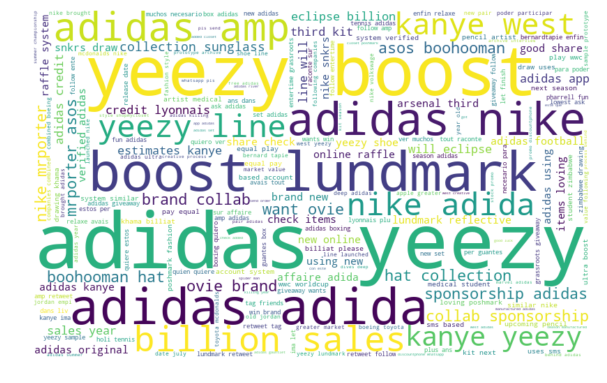

In [266]:
wordcloud(adidas)

### 4 Sentiment Analysis

In [0]:
def textblob_sentiment(dataframe,column):
  text = pd.DataFrame()
  text['text'] = dataframe[column]
  for index, row in text.iterrows():
    blob = TextBlob(str(text.at[index,'text']))
    text.at[index,'polarity'] = str(blob.sentiment.polarity)
    text.at[index,'subjectivity'] = str(blob.sentiment.subjectivity)
  return text

In [347]:
sentiment_analysis = textblob_sentiment(adidas,'optimized_text')
sentiment_analysis.head(5)

,text,polarity,subjectivity
0,adidas golden glove sari van veenendaal #ned#f...,0.3,0.5
1,adidas golden ball megan rapinoe #usa lucy bro...,0.44999999999999996,0.725
2,adidas golden ball megan rapinoe #usa lucy bro...,0.44999999999999996,0.725
3,adidas sale more code needed via men,0.5,0.5
4,alegra saber que mezcla adidas con nike,0.0,0.0


## 5 Optional: Detect and Transform Language

### 5.1 Detect text length of Tweets

Textblob uses the Google Translate API for detecting languages. The API requires at least three characters. Therefore we need to remove transformed Tweet texts, that are shorter than three characters.

In [0]:
def detect_length(input_df):
  '''Detect character length of each row for a given column'''
  len = pd.DataFrame()
  len['text_length'] = input_df['optimized_text'].str.len()
  return len

In [0]:
vonovia = vonovia.join(detect_length(vonovia))

In [308]:
vonovia.head()

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text,optimized_umlauts,optimized_text,text_length
0,499903861,Holde Maid,2019-07-08 19:18:46,624.0,vonovia,NaN,@strangeoldwoman Kenne Vonovia intern nicht. '...,@strangeoldwoman Kenne Vonovia intern nicht. '...,kenne vonovia intern nicht meine verwaltung al...,88
1,1049301688572678144,Strange OldWoman,2019-07-08 19:15:26,644.0,vonovia,NaN,RT @strangeoldwoman: @HoldeMaid666 Hier nicht ...,RT @strangeoldwoman: @HoldeMaid666 Hier nicht ...,hier nicht vermieter vonovia mieter tochter un...,96
2,1049301688572678144,Strange OldWoman,2019-07-08 19:13:58,644.0,vonovia,NaN,@HoldeMaid666 Hier nicht Vermieter Vonovia Mie...,@HoldeMaid666 Hier nicht Vermieter Vonovia Mie...,hier nicht vermieter vonovia mieter tochter un...,94
3,2545723530,â€martina scheefeldt â€,2019-07-08 16:16:53,779.0,vonovia,NaN,Vonovia: So profitiert der Konzern von der Woh...,Vonovia: So profitiert der Konzern von der Woh...,vonovia profitiert der konzern von der wohnung...,61
4,1100125724332171264,Mieter_Vonovia,2019-07-08 11:28:10,98.0,vonovia,NaN,@uf0_x @Rolf_Buch Mehrwert Ã¼bersetzt:\nâ–¶ï¸...,@uf0_x @Rolf_Buch Mehrwert uebersetzt:â–¶ï¸ R...,mehrwert uebersetz rendite die #vonovia ist wi...,84


### 5.2 Remove Tweets with less than two characters

In [0]:
# Remove Tweet texts that contain less than three characters
vonovia =  vonovia[vonovia['text_length'] > 2].reset_index(drop=True)

In [285]:
vonovia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 10 columns):
user_id              105 non-null object
user_name            105 non-null object
time                 105 non-null object
follower_count       105 non-null float64
tweet_keyword        105 non-null object
retweet_count        0 non-null object
text                 105 non-null object
optimized_umlauts    105 non-null object
optimized_text       105 non-null object
text_length          105 non-null int64
dtypes: float64(1), int64(1), object(8)
memory usage: 8.3+ KB


### 5.3 Detect language

In [0]:
def detect_language(input_df):
  '''Function to detect language with Textblob'''
  detect = pd.DataFrame()
  detect['text'] = input_df['optimized_text']
  for index, row in detect.iterrows():
    blob = TextBlob(str(detect.at[index,'text']))
    language = blob.detect_language()
    detect.at[index,'language'] = language
  detect = detect.drop(['text'], axis=1)
  return detect

In [0]:
vonovia = df.join(detect_language(vonovia))

In [332]:
vonovia.head()

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text,optimized_umlauts,optimized_text,text_length,language
0,499903861,Holde Maid,2019-07-08 19:18:46,624.0,vonovia,NaN,@strangeoldwoman Kenne Vonovia intern nicht. '...,@strangeoldwoman Kenne Vonovia intern nicht. '...,kenne vonovia intern nicht meine verwaltung al...,88,de
1,1049301688572678144,Strange OldWoman,2019-07-08 19:15:26,644.0,vonovia,NaN,RT @strangeoldwoman: @HoldeMaid666 Hier nicht ...,RT @strangeoldwoman: @HoldeMaid666 Hier nicht ...,hier nicht vermieter vonovia mieter tochter un...,96,de
2,1049301688572678144,Strange OldWoman,2019-07-08 19:13:58,644.0,vonovia,NaN,@HoldeMaid666 Hier nicht Vermieter Vonovia Mie...,@HoldeMaid666 Hier nicht Vermieter Vonovia Mie...,hier nicht vermieter vonovia mieter tochter un...,94,de
3,2545723530,â€martina scheefeldt â€,2019-07-08 16:16:53,779.0,vonovia,NaN,Vonovia: So profitiert der Konzern von der Woh...,Vonovia: So profitiert der Konzern von der Woh...,vonovia profitiert der konzern von der wohnung...,61,de
4,1100125724332171264,Mieter_Vonovia,2019-07-08 11:28:10,98.0,vonovia,NaN,@uf0_x @Rolf_Buch Mehrwert Ã¼bersetzt:\nâ–¶ï¸...,@uf0_x @Rolf_Buch Mehrwert uebersetzt:â–¶ï¸ R...,mehrwert uebersetz rendite die #vonovia ist wi...,84,de


### 5.4 Translate text from detected language to English

In [0]:
def translate(input_df):
  '''Function with TextBlob class'''
  translation = pd.DataFrame()
  translation = input_df
  for index, row in translation.iterrows():
    blob = TextBlob(str(translation.at[index,'text']))
    translated_tweet = blob.translate(from_lang=str(translation.at[index,'language']), to='en')
    translation.at[index,'translated_text'] = translated_tweet
  translation = translation.drop(['text'], axis=1)
  return translation

In [0]:
def google_translate(input_df):
  '''Function with Google Trans module class'''
  translation = pd.DataFrame()
  translation = input_df[['optimized_text','language']]
  for index, row in translation.iterrows():
    translator = Translator()
    translated_tweet = translator.translate(str(translation.at[index,'optimized_text']), src=str(translation.at[index,'language']),dest='en')
    translation.at[index,'translated_text'] = translated_tweet.text
  translation = translation.drop(['optimized_text','language'], axis=1)
  return translation

In [0]:
vonovia = df.join(google_translate(vonovia))

In [345]:
vonovia.head()

,user_id,user_name,time,follower_count,tweet_keyword,retweet_count,text,optimized_umlauts,optimized_text,translated_text
0,1034712035559399424,Spielverderber,2019-07-07 18:30:43,4.0,lufthansa,0,"Hallo @Lufthansa_DE , ich habe vermutlich mein...","Hallo @Lufthansa_DE , ich habe vermutlich mein...",hallo ich habe vermutlich meine airpods fliege...,internally vonovia not my administration so my...
1,601736229,Venkat,2019-07-07 18:28:55,5.0,lufthansa,1,RT @nirmaldamani: @AUStinAirport @JetBlue @emi...,RT @nirmaldamani: @AUStinAirport @JetBlue @emi...,thank you dylan davis for helping look multipl...,here not landlord vonovia tenant daughter subt...
2,3319350989,Kai_Low0n,2019-07-07 18:23:52,2.0,lufthansa,0,"@lufthansa nice joke, texting with a bot for p...","@lufthansa nice joke, texting with a bot for p...",nice joke texting with bot for probably anothe...,here not landlord vonovia tenant daughter subt...
3,124476322,Lufthansa,2019-07-07 18:22:21,431976.0,lufthansa,0,@kai_low0n I would like to ask you to contact ...,@kai_low0n I would like to ask you to contact ...,would like ask you contact via our lufthansa c...,vonovia benefits the group from the housing sh...
4,398803040,SOPLANE NIK,2019-07-07 18:22:21,1320.0,lufthansa,0,@thomas_boon @lufthansa https://t.co/qJZWOx2wJB,@thomas_boon @lufthansa https://t.co/qJZWOx2wJB,,value translating the #vonovia is like #deutsc...


### 5.5 Sentiment analysis on translated Tweet

In [349]:
vonovia_sentiment = textblob_sentiment(vonovia,'translated_text')
vonovia_sentiment.head(5)

,text,polarity,subjectivity
0,internally vonovia not my administration so my...,0.0,0.0
1,here not landlord vonovia tenant daughter subt...,0.0,0.0
2,here not landlord vonovia tenant daughter subt...,0.0,0.0
3,vonovia benefits the group from the housing sh...,0.0,0.0
4,value translating the #vonovia is like #deutsc...,0.0,0.0


## 6 Upcoming Tasks

1.   Remove Stopwords (not only for wordcloud)
2.   Count average Tweet length
3.   Count average number of Retweets
4.   Detect influencer in area (unique user order by average number of follower)
5.   Sentiment Classifier

